In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/master/notebooks/official/vizier/gapic-vizier-multi-objective-optimization.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/master/notebooks/official/vizier/gapic-vizier-multi-objective-optimization.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# Optimizing multiple objectives

This tutorial demonstrates [Vertex Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview) multi-objective optimization. Multi-objective optimization is concerned with mathematical optimization problems involving more than one objective function to be optimized simultaneously

### Objective



### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.


#### Install Vertex AI library

Download and install Vertex AI library.

In [1]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [2]:
! pip install {USER_FLAG} --upgrade google-cloud-aiplatform

In [7]:
import os

if not os.getenv("IS_TESTING"):
    # Restart the kernel after pip installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project.](https://console.cloud.google.com/cloud-resource-manager)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the Vertex AI APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
right project is used for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Authenticate your Google Cloud account

**If you are using [Google Cloud Notebooks](https://cloud.google.com/ai-platform/notebooks/docs/)**, your environment is already
authenticated. Skip these steps.

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on Google Cloud Notebooks, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Enable cloud billing API

In [6]:
!pip install google-cloud-billing lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 29.1 MB/s eta 0:00:0000:0100:01


In [1]:
!#gcloud services list --available | grep billing
!gcloud services enable cloudbilling.googleapis.com

Operation "operations/acat.p2-712758616004-62cd66d2-3fd2-4255-92dd-be9f4e8d9f2d" finished successfully.


### Import libraries and define constants

In [109]:
import datetime
import json

from google.cloud import aiplatform

## Cost Optimization


This section defines some parameters and util methods to call Vertex Vizier APIs. Please fill in the following information to get started.

In [110]:
# Fill in your project ID and region
REGION = "us-central1"  # @param {type:"string"}
PROJECT_ID = "sungyong-internship"  # @param {type:"string"}

# These will be automatically filled in.
STUDY_DISPLAY_NAME = "{}_study_{}".format(
    PROJECT_ID.replace("-", ""), datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
)  # @param {type: 'string'}
ENDPOINT = REGION + "-aiplatform.googleapis.com"
PARENT = "projects/{}/locations/{}".format(PROJECT_ID, REGION)

print("ENDPOINT: {}".format(ENDPOINT))
print("REGION: {}".format(REGION))
print("PARENT: {}".format(PARENT))

# If you don't know your project ID, you might be able to get your project ID
# using gcloud command by executing the second cell below.
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)
! gcloud config set project $PROJECT_ID

ENDPOINT: us-central1-aiplatform.googleapis.com
REGION: us-central1
PARENT: projects/sungyong-internship/locations/us-central1
Updated property [core/project].


In [11]:
import pandas as pd

table_vertex_compute = pd.read_html('https://cloud.google.com/vertex-ai/docs/training/configure-compute', attrs={"id": "gpu-compatibility-table"})[0]

table_vertex_compute.columns = table_vertex_compute.columns.droplevel(0)
table_vertex_compute


,Machine type,NVIDIA_TESLA_A100,NVIDIA_TESLA_K80,NVIDIA_TESLA_P4,NVIDIA_TESLA_P100,NVIDIA_TESLA_T4,NVIDIA_TESLA_V100
0,a2-highgpu-1g,1.0,NaN,NaN,NaN,NaN,NaN
1,a2-highgpu-2g,2.0,NaN,NaN,NaN,NaN,NaN
2,a2-highgpu-4g,4.0,NaN,NaN,NaN,NaN,NaN
3,a2-highgpu-8g,8.0,NaN,NaN,NaN,NaN,NaN
4,a2-megagpu-16g,16.0,NaN,NaN,NaN,NaN,NaN
5,n1-standard-4,NaN,"1, 2, 4, 8","1, 2, 4","1, 2, 4","1, 2, 4","1, 2, 4, 8"
6,n1-standard-8,NaN,"1, 2, 4, 8","1, 2, 4","1, 2, 4","1, 2, 4","1, 2, 4, 8"
7,n1-standard-16,NaN,"2, 4, 8","1, 2, 4","1, 2, 4","1, 2, 4","2, 4, 8"
8,n1-standard-32,NaN,"4, 8","2, 4","2, 4","2, 4","4, 8"
9,n1-standard-64,NaN,NaN,4,NaN,4,8


In [12]:
GPUS = table_vertex_compute.columns.tolist()[1:]
GPUS

['NVIDIA_TESLA_A100',
 'NVIDIA_TESLA_K80',
 'NVIDIA_TESLA_P4',
 'NVIDIA_TESLA_P100',
 'NVIDIA_TESLA_T4',
 'NVIDIA_TESLA_V100']

In [13]:
MACHINE_SHAPES = table_vertex_compute['Machine type'].tolist()
MACHINE_SHAPES

['a2-highgpu-1g',
 'a2-highgpu-2g',
 'a2-highgpu-4g',
 'a2-highgpu-8g',
 'a2-megagpu-16g',
 'n1-standard-4',
 'n1-standard-8',
 'n1-standard-16',
 'n1-standard-32',
 'n1-standard-64',
 'n1-standard-96',
 'n1-highmem-2',
 'n1-highmem-4',
 'n1-highmem-8',
 'n1-highmem-16',
 'n1-highmem-32',
 'n1-highmem-64',
 'n1-highmem-96',
 'n1-highcpu-16',
 'n1-highcpu-32',
 'n1-highcpu-64',
 'n1-highcpu-96']

### Create the study configuration

The following is a sample study configuration, built as a hierarchical python dictionary. It is already filled out. Run the cell to configure the study.

In [459]:
import json


#RJV - Hardcoding for testing - these values will be populated by the dataframe above
param_machine_type = {"parameter_id": "machine_type","categorical_value_spec": {"values":["n1-standard-4","n1-standard-8"]}}

param_gpu_type = {"parameter_id": "gpu_type","categorical_value_spec": {"values":["NVIDIA_TESLA_K80","NVIDIA_TESLA_P4","NVIDIA_TESLA_P100","NVIDIA_TESLA_T4","NVIDIA_TESLA_V100"]}}

param_gpu_count = {"parameter_id": "gpu_count","discrete_value_spec": {"values":[1,2,4]}}
# - maybe only explore - 2 & 8 (if it is, then maybe just 2)


# Objective Metrics
metric_training_time = {"metric_id": "training_time", "goal": "MINIMIZE"}

metric_estimated_training_cost = {"metric_id": "estimated_training_cost", "goal": "MINIMIZE"}

metric_gpu_utilization = {"metric_id": "average_gpu_utilization", "goal": "MAXIMIZE"}


# Put it all together in a study configuration
study = {
    "display_name": 'Tabnet_GPU_Cost_Optimization_v2',
    "study_spec": {
        #"algorithm": "RANDOM_SEARCH",
        "parameters": [
            param_machine_type,
            param_gpu_type,
            param_gpu_count,
        ],
        "metrics": [metric_training_time, metric_estimated_training_cost, metric_gpu_utilization],
    },
}

print(json.dumps(study, indent=2, sort_keys=True))

{
  "display_name": "Tabnet_GPU_Cost_Optimization_v2",
  "study_spec": {
    "metrics": [
      {
        "goal": "MINIMIZE",
        "metric_id": "training_time"
      },
      {
        "goal": "MINIMIZE",
        "metric_id": "estimated_training_cost"
      },
      {
        "goal": "MAXIMIZE",
        "metric_id": "average_gpu_utilization"
      }
    ],
    "parameters": [
      {
        "categorical_value_spec": {
          "values": [
            "n1-standard-4",
            "n1-standard-8"
          ]
        },
        "parameter_id": "machine_type"
      },
      {
        "categorical_value_spec": {
          "values": [
            "NVIDIA_TESLA_K80",
            "NVIDIA_TESLA_P4",
            "NVIDIA_TESLA_P100",
            "NVIDIA_TESLA_T4",
            "NVIDIA_TESLA_V100"
          ]
        },
        "parameter_id": "gpu_type"
      },
      {
        "discrete_value_spec": {
          "values": [
            1,
            2,
            4
          ]
        },
  

### Create the study

Next, create the study, which you will subsequently run to optimize the two objectives.

In [460]:
vizier_client = aiplatform.gapic.VizierServiceClient(
    client_options=dict(api_endpoint=ENDPOINT)
)
study = vizier_client.create_study(parent=PARENT, study=study)
STUDY_ID = study.name
print("STUDY_ID: {}".format(STUDY_ID))

E0519 15:26:38.053516013   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


STUDY_ID: projects/497728924767/locations/us-central1/studies/1027326038140


In [451]:
### Delete study
vizier_client.delete_study({'name':'projects/497728924767/locations/us-central1/studies/527434739702'})

### Hourly (list) prices for machine/gpu configurations

In [93]:
from google.cloud import billing_v1
import re

CACHED_PRICES=False
GPU_PRICES= {}
INSTANCE_CORE_PRICES = {}
INSTANCE_RAM_PRICES = {}

def normalize_price(response):
    unit_price = response.pricing_info[0].pricing_expression.tiered_rates[0].unit_price
    cents = unit_price.nanos/1000000000
    if hasattr(unit_price, 'units'):
        price= unit_price.units + cents
    else:
        price = cents
    return price

def get_machine_specs(machine_shape):
    m_class,m_type,m_cores = machine_shape.split('-')
    if m_class == 'a2':
        #12 vcpu, 85 Gb RAM per gpu
        gpus,_ = m_cores.split('g')
        gpus = int(gpus)
        return {'class':m_class,'cores':  gpus * 12, 'ram': gpus * 72 }
    elif m_class == 'n1':
        #n1-standard: 3.75 Gb RAM per core
        if m_type == 'standard':
            mult = 3.75        
        #n1-highmem: 6.5 Gb RAM per core
        if m_type == 'highmem':
            mult = 6.5
         #n1-highcpu: 1.8 Gb RAM per core
        if m_type == 'highcpu':
            mult = 1.8
        return {'class':m_class,'cores':  int(m_cores), 'ram': int(m_cores) * mult }
    elif m_class == 'e2' or m_class == 'c2':
        #e2-standard: 4 Gb RAM per core
        if m_type == 'standard':
            mult = 4        
        #e2-highmem: 8 Gb RAM per core
        if m_type == 'highmem':
            mult = 8
         #e2-highcpu: 1 Gb RAM per core
        if m_type == 'highcpu':
            mult = 1
        return {'class':m_class,'cores':  int(m_cores), 'ram': int(m_cores) * mult }


def get_hourly_price(machine_shape, gpu_type='ACCELERATOR_TYPE_UNSPECIFIED', gpu_count=0):
    global CACHED_PRICES
    
    # Create a client
    
    if not CACHED_PRICES:
        client = billing_v1.CloudCatalogClient()

        # Initialize request argument(s)
        request = billing_v1.ListSkusRequest(
            parent="services/C7E2-9256-1C43",
        )

        # Make the request
        page_result = client.list_skus(request=request)

        # Look specifically for Vertex AI Training Americas
        for response in page_result:
            #print(response)
            #GPU
            match = re.match(r'Vertex AI: Training/Pipelines.+Nvidia.+Americas',response.description)
            if match is not None:
                for gpu in GPUS:
                    _,gpu_id = gpu.split('NVIDIA_TESLA_')
                    gpu_match = re.search(gpu_id,response.description)
                    if gpu_match is not None:
                        price = normalize_price(response)
                        GPU_PRICES[gpu]=price
            match = re.match(r'Vertex AI: Training/Pipelines.+N1.+Americas',response.description)
            if match is not None:
                instance_match = re.search("Instance Core",response.description)
                if instance_match is not None:
                    price = normalize_price(response)
                    INSTANCE_CORE_PRICES['n1']=price
                ram_match = re.search("Instance Ram",response.description)
                if ram_match is not None:
                    price = normalize_price(response)
                    INSTANCE_RAM_PRICES['n1']=price
            match = re.match(r'Vertex AI: Training/Pipelines.+A2.+Americas',response.description)
            if match is not None:
                instance_match = re.search("Instance Core",response.description)
                if instance_match is not None:
                    price = normalize_price(response)
                    INSTANCE_CORE_PRICES['a2']=price
                ram_match = re.search("Instance Ram",response.description)
                if ram_match is not None:
                    price = normalize_price(response)
                    INSTANCE_RAM_PRICES['a2']=price
            match = re.match(r'Vertex AI: Training/Pipelines.+E2.+Americas',response.description)
            if match is not None:
                instance_match = re.search("Instance Core",response.description)
                if instance_match is not None:
                    price = normalize_price(response)
                    INSTANCE_CORE_PRICES['e2']=price
                ram_match = re.search("Instance Ram",response.description)
                if ram_match is not None:
                    price = normalize_price(response)
                    INSTANCE_RAM_PRICES['e2']=price
            match = re.match(r'Vertex AI: Training/Pipelines.+Compute optimized.+Americas',response.description)
            if match is not None:
                instance_match = re.search("Core",response.description)
                if instance_match is not None:
                    price = normalize_price(response)
                    INSTANCE_CORE_PRICES['c2']=price
                ram_match = re.search("Ram",response.description)
                if ram_match is not None:
                    price = normalize_price(response)
                    INSTANCE_RAM_PRICES['c2']=price
        CACHED_PRICES=True
        
        #Adding 'Unspecified' type for CPU-only jobs
        GPU_PRICES['ACCELERATOR_TYPE_UNSPECIFIED']=0
    
    # Calculate prices
    machine_specs = get_machine_specs(machine_shape)
    # if CACHED_PRICES:
    #     print(machine_specs)
    
#     print(f'instance_core_prices{instance_core_prices}')
#     print(f'instance_ram_prices{instance_ram_prices}')

    #Total should be per-hour core charge + per-hour RAM GiB charge + GPU hourly charge
    if machine_specs['class']=='n1':
        return (machine_specs['cores'] * INSTANCE_CORE_PRICES['n1']) + (machine_specs['ram'] * INSTANCE_RAM_PRICES['n1']) + (GPU_PRICES[gpu_type] * gpu_count)
    
    if machine_specs['class']=='a2':
        return (machine_specs['cores'] * INSTANCE_CORE_PRICES['a2']) + (machine_specs['ram'] * INSTANCE_RAM_PRICES['a2']) + (GPU_PRICES[gpu_type] * gpu_count)
    
    if machine_specs['class']=='e2':
        return (machine_specs['cores'] * INSTANCE_CORE_PRICES['e2']) + (machine_specs['ram'] * INSTANCE_RAM_PRICES['e2']) + (GPU_PRICES[gpu_type] * gpu_count)
    
    if machine_specs['class']=='c2':
        return (machine_specs['cores'] * INSTANCE_CORE_PRICES['c2']) + (machine_specs['ram'] * INSTANCE_RAM_PRICES['c2']) + (GPU_PRICES[gpu_type] * gpu_count)
    

In [100]:
#get_hourly_price('n1-standard-4','NVIDIA_TESLA_T4',1)
#get_hourly_price('e2-standard-4')
get_hourly_price('c2-standard-8')

0.4802584

### Calculating costs for training and HPT jobs

In [237]:
from google.cloud import aiplatform

from datetime import datetime, timedelta

import pandas as pd

def get_gpu_utilization(project_id, job_id, start_time, end_time,trial_id):
    from google.cloud import monitoring_v3

    client = monitoring_v3.MetricServiceClient()
    project_name = f"projects/{project_id}"
    
    interval = monitoring_v3.TimeInterval(
        {
            "end_time": end_time,
            #"end_time": {"seconds": end_time},
            "start_time": start_time,
            #"start_time": {"seconds": start_time},

        }
    )
    
    aggregation = monitoring_v3.Aggregation(
        {
            "alignment_period": {"seconds": 3600 * 24},  # 24 hours
            "per_series_aligner": monitoring_v3.Aggregation.Aligner.ALIGN_MEAN,
            "cross_series_reducer": monitoring_v3.Aggregation.Reducer.REDUCE_NONE,
        }
    )
        
    filter = f'metric.type = "ml.googleapis.com/training/accelerator/utilization" AND resource.type="cloudml_job" AND resource.labels.job_id ="{job_id}"'
    
    if trial_id:
        filter += f' AND metric.labels.trial_id = "{trial_id}"'

    results = client.list_time_series(
        request={
            "name": project_name,
            "filter": filter,
            "interval": interval,
            "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
            "aggregation": aggregation,
        }
    )
    
    gpu_utilization = -1
    for result in results:
        #print(f"utilization: {result.points[0].value.double_value}")
        gpu_utilization = result.points[0].value.double_value
        break
    return gpu_utilization

def get_job_details(
    project: str,
    custom_job: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)
    name = client.custom_job_path(
        project=project, location=location, custom_job=custom_job
    )
    response = client.get_custom_job(name=name)
    machine_spec = response.job_spec.worker_pool_specs[0].machine_spec
    #print(machine_spec)
    #print(response)
    #print(f'response state is: {response.state.name}')

    gpu_utilization = get_gpu_utilization(project, custom_job, response.start_time, response.end_time)
    job_duration = (response.end_time - response.start_time)/timedelta(hours=1)
    
    job_cost = get_hourly_price(machine_spec.machine_type, machine_spec.accelerator_type.name,machine_spec.accelerator_count) * job_duration
    
    return {'machine_type': machine_spec.machine_type, 
            'accelerator_type':machine_spec.accelerator_type.name,
            'accelerator_count':machine_spec.accelerator_count,
            'gpu_utilization':gpu_utilization,
            'job_duration_hours': job_duration,
            'job_cost': job_cost}


def get_hpt_job_details(
    project: str,
    hyperparameter_tuning_job: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.JobServiceClient(client_options=client_options)
    name = client.hyperparameter_tuning_job_path(
        project=project, location=location, hyperparameter_tuning_job=hyperparameter_tuning_job
    )
    response = client.get_hyperparameter_tuning_job(name=name)
    #print(response)
    machine_spec = response.trial_job_spec.worker_pool_specs[0].machine_spec
    
    
    
    total_trials = len(response.trials)
    total_job_duration = 0
    total_job_cost = 0
    agg_gpu_utilization = 0
    trial_dict = {"trial_id":[],"job_duration":[],"job_cost":[],"gpu_utilization":[]}
    
    hpt_trial_start_time = hpt_trial_end_time = 0
    
    for trial in response.trials:
        if trial.id == '1':
            hpt_trial_start_time = trial.start_time
            
        if trial.end_time:
            job_duration = (trial.end_time - trial.start_time)/timedelta(hours=1)
            job_cost = get_hourly_price(machine_spec.machine_type, machine_spec.accelerator_type.name,machine_spec.accelerator_count) * job_duration
            
            gpu_utilization = get_gpu_utilization(project, hyperparameter_tuning_job,trial.start_time, trial.end_time, trial.id)
            
            trial_dict['trial_id'].append(trial.id)
            trial_dict['job_duration'].append(job_duration)
            trial_dict['job_cost'].append(job_cost)
            trial_dict['gpu_utilization'].append(gpu_utilization)
            
            total_job_duration+=job_duration
            total_job_cost += job_cost
            agg_gpu_utilization+=gpu_utilization
            
            #Lazily setting last trial's end time to hpt end time
            hpt_trial_end_time = trial.end_time

    # GPU Utilization for HPT Trials is provided at the HPT job level, not the trial level
    # Grab all GPU utilization over that period of time
    # Put it in a dict that can be looked up by trial ID below
    
    
    trial_df = pd.DataFrame.from_dict(trial_dict)
    #trial_df.set_index('trial_id')
    
    # plt = trial_df.plot(y='job_cost',figsize=(20,6))
    # plt.set_xlabel('trial #')
    # plt.set_ylabel('trial cost ($)')
    
    return {'machine_type': machine_spec.machine_type, 
            'accelerator_type':machine_spec.accelerator_type.name,
            'accelerator_count':machine_spec.accelerator_count,
            'avg_gpu_utilization':agg_gpu_utilization/total_trials,
            'hpt_job_cumulative_duration_hours': total_job_duration,
            'hpt_total_trials': total_trials,
            'hpt_trials_per_training_hour' : total_trials/total_job_duration,
            'job_cost': total_job_cost,
            'job_cost_per_trial_hour':total_job_cost/total_job_duration,
            'job_cost_per_trial':total_job_cost/total_trials,
            'trial_details':trial_df
           }



In [238]:
get_hpt_job_details(PROJECT_ID,'6942514604748570624')

{'machine_type': 'n1-highmem-8',
 'accelerator_type': 'NVIDIA_TESLA_T4',
 'accelerator_count': 2,
 'avg_gpu_utilization': 0.2506714346276643,
 'hpt_job_cumulative_duration_hours': 598.7388977747223,
 'hpt_total_trials': 104,
 'hpt_trials_per_training_hour': 0.17369841910476705,
 'job_cost': 807.8148086964889,
 'job_cost_per_trial_hour': 1.3491937999999994,
 'job_cost_per_trial': 7.767450083620085,
 'trial_details':     trial_id  job_duration   job_cost  gpu_utilization
 0          1     18.762829  25.314692         0.227654
 1          2     21.933106  29.592011         0.210682
 2          3      5.112273   6.897447         0.282492
 3          4     32.299495  43.578279         0.132632
 4          5     23.175328  31.268009         0.189830
 ..       ...           ...        ...              ...
 98       100      4.537244   6.121622         0.276474
 99       101      5.650149   7.623146         0.310090
 100      102      4.065387   5.484995         0.219438
 101      103      5.4

Results for job id: 7085503892917583872, machine-type: a2-highgpu-1g, accel: NVIDIA_TESLA_A100, accel_count: 1

machine_type: a2-highgpu-1g
accelerator_type: NVIDIA_TESLA_A100
accelerator_count: 1
avg_gpu_utilization: 0.26297279303615967
hpt_job_cumulative_duration_hours: 491.42305038666666
hpt_total_trials: 104
hpt_trials_per_training_hour: 0.2116302845749088
job_cost: 2044.8356872422191
job_cost_per_trial_hour: 4.1610496
job_cost_per_trial: 19.661881608098263

Descriptive stats
       job_duration    job_cost
count    104.000000  104.000000
mean       4.725222   19.661882
std        0.568222    2.364400
min        2.664327   11.086399
25%        4.501189   18.729672
50%        4.703229   19.570370
75%        4.957938   20.630227
max        6.971877   29.010327



Results for job id: 6942514604748570624, machine-type: n1-highmem-8, accel: NVIDIA_TESLA_T4, accel_count: 2

machine_type: n1-highmem-8
accelerator_type: NVIDIA_TESLA_T4
accelerator_count: 2
avg_gpu_utilization: 0.2506714346

Text(0, 0.5, 'trial cost ($)')

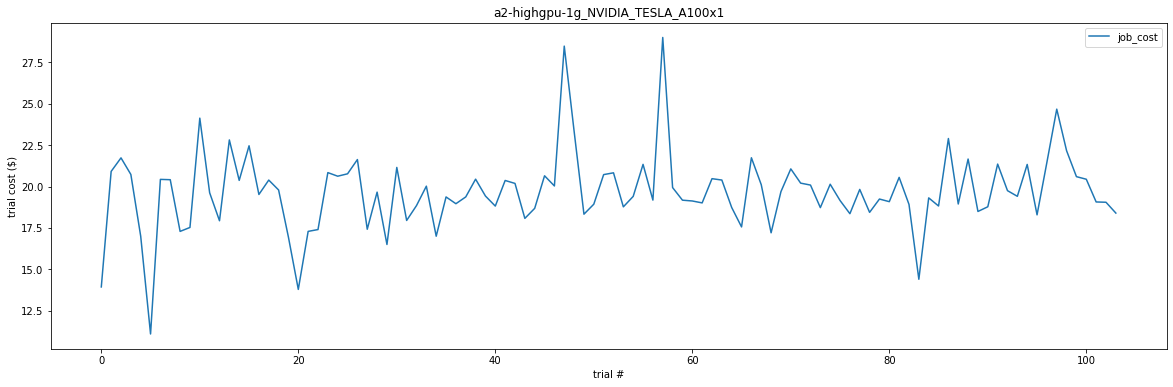

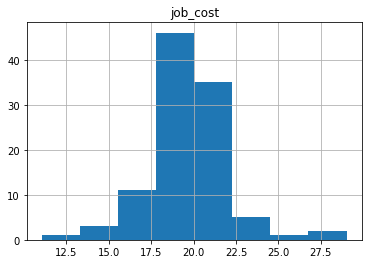

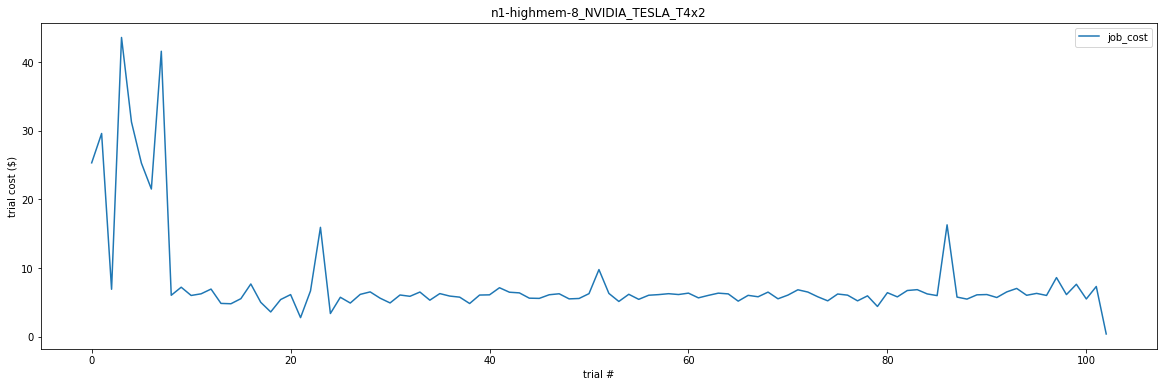

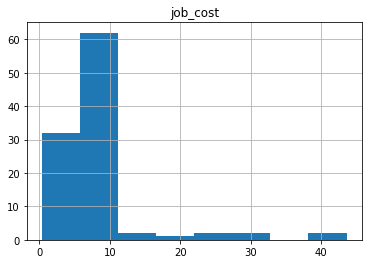

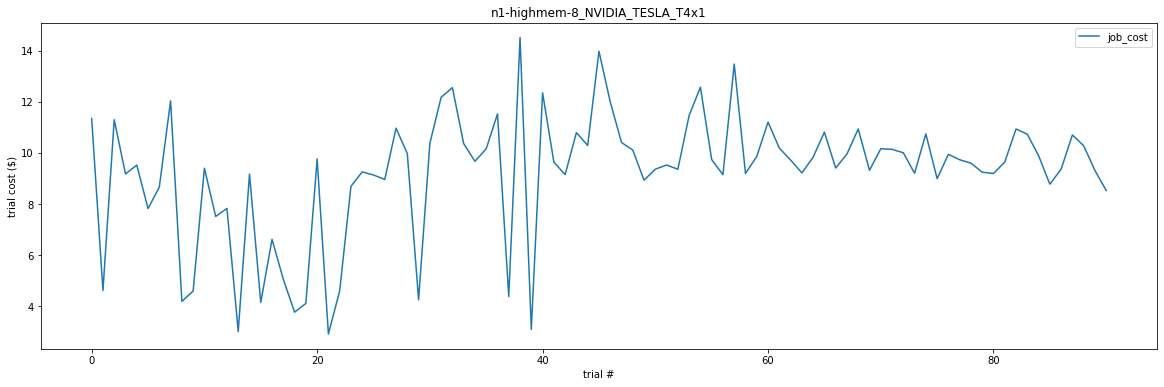

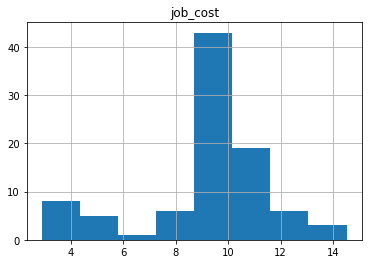

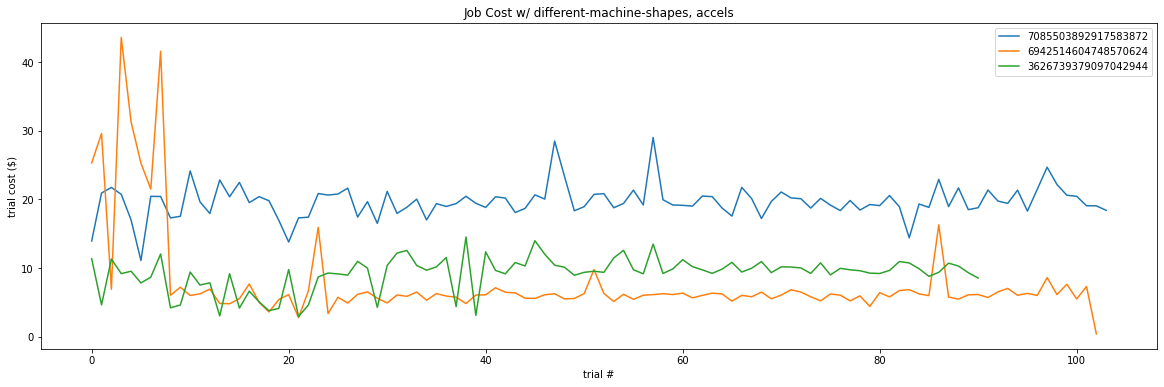

In [236]:
#Compare and graph 3 jobs
# Avg trial duration
# Descriptive stats of trial
# Avg trial cost

import json

results = {}
#jobs = ['9215224105937141760','8692138046092476416','5067021821035937792']
#jobs = ['4584978331232894976','846498059306139648','2076754813764239360']

#jobs = ['846498059306139648','2076754813764239360']

jobs = ['7085503892917583872','6942514604748570624','3626739379097042944']

#jobs = ['7085503892917583872']



for job in jobs:
    results[job] = get_hpt_job_details(PROJECT_ID,job)
    print(f"Results for job id: {job}, machine-type: {results[job]['machine_type']}, accel: {results[job]['accelerator_type']}, accel_count: {results[job]['accelerator_count']}\n")
    for key, val in results[job].items():
        if key != 'trial_details':
            print(f"{key}: {val}")
    print("\nDescriptive stats")
    print(results[job]['trial_details'].describe())
    print('\n\n')
    df = results[job]['trial_details']
    title=f"{results[job]['machine_type']}_{results[job]['accelerator_type']}x{results[job]['accelerator_count']}"
    axs = df.plot(y='job_cost',figsize=(20,6),title=title)
    axs.set_xlabel('trial #')
    axs.set_ylabel('trial cost ($)')
    df.hist(column='job_cost',bins=8)
    
dfs = [results[job]['trial_details'] for job in jobs]
concat_dfs = pd.concat(dfs, keys=jobs)
p = concat_dfs.unstack(level=0).plot(y='job_cost',figsize=(20,6),title='Job Cost w/ different-machine-shapes, accels')
p.set_xlabel('trial #')
p.set_ylabel('trial cost ($)')


{'machine_type': 'n1-highmem-8',
 'accelerator_type': 'NVIDIA_TESLA_T4',
 'accelerator_count': 2,
 'gpu_utilization': -1,
 'hpt_job_cumulative_duration_hours': 230.29125327083327,
 'hpt_total_trials': 147,
 'hpt_trials_per_training_hour': 0.6383221156346791,
 'job_cost': 310.70753110723814,
 'job_cost_per_trial_hour': 1.3491938000000008,
 'job_cost_per_trial': 2.1136566741988987,
 'trial_details':     trial_id  job_duration  job_cost
 0          1      2.427076  3.274596
 1          2      1.607354  2.168632
 2          3      2.136243  2.882206
 3          4      0.997362  1.345635
 4          5      1.702267  2.296688
 ..       ...           ...       ...
 139      140      1.634592  2.205382
 140      141      1.489641  2.009814
 141      142      1.593405  2.149812
 142      143      1.585962  2.139770
 143      144      1.675730  2.260884
 
 [144 rows x 3 columns]}

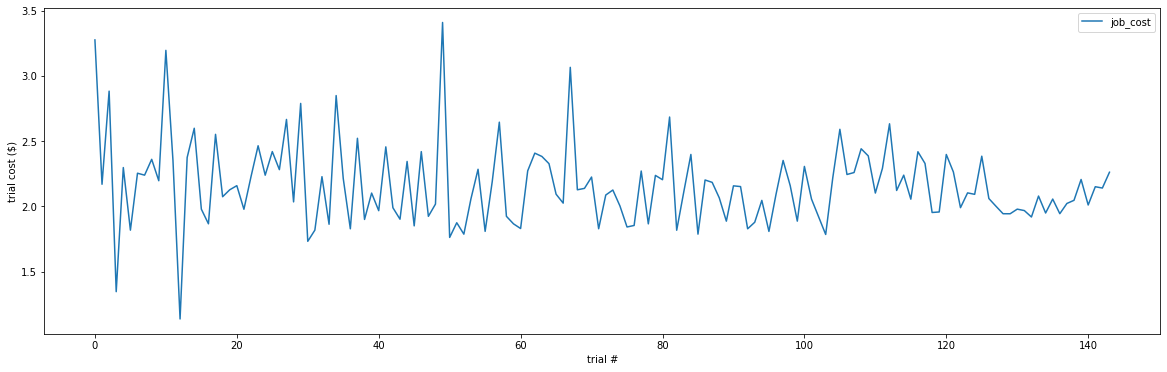

In [132]:
# Current job with 2 T4s
get_hpt_job_details(PROJECT_ID,'9215224105937141760')

In [60]:
# Current job with 2 T4s
get_hpt_job_details(PROJECT_ID,'9215224105937141760')

{'machine_type': 'n1-highmem-8',
 'accelerator_type': 'NVIDIA_TESLA_T4',
 'accelerator_count': 2,
 'gpu_utilization': -1,
 'hpt_job_cumulative_duration_hours': 151.3344222955555,
 'hpt_total_trials': 97,
 'hpt_trials_per_training_hour': 0.6409645507521046,
 'job_cost': 204.1794642877454,
 'job_cost_per_trial_hour': 1.349193800000001,
 'job_cost_per_trial': 2.104942930801499}

{'machine_type': 'a2-highgpu-2g',
 'accelerator_type': 'NVIDIA_TESLA_A100',
 'accelerator_count': 2,
 'gpu_utilization': -1,
 'hpt_job_cumulative_duration_hours': 156.9920183608333,
 'hpt_total_trials': 134,
 'hpt_trials_per_training_hour': 0.8535465777120718,
 'job_cost': 1306.5031504070764,
 'job_cost_per_trial_hour': 8.322099200000002,
 'job_cost_per_trial': 9.75002351050057,
 'trial_details':     trial_id  job_duration   job_cost
 0          1      1.389558  11.564037
 1          2      1.464835  12.190506
 2          3      1.377058  11.460010
 3          4      1.595242  13.275761
 4          5      0.831401   6.918999
 ..       ...           ...        ...
 126      127      1.134006   9.437309
 127      128      1.064309   8.857281
 128      129      1.626749  13.537966
 129      130      1.143395   9.515445
 130      131      1.078999   8.979535
 
 [131 rows x 3 columns]}

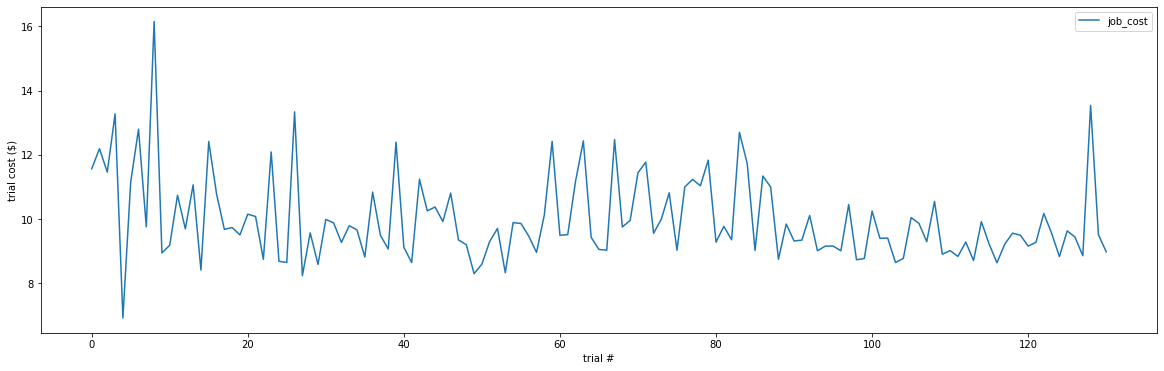

In [133]:
#Same job with 2 A100s
get_hpt_job_details(PROJECT_ID,'8692138046092476416')

In [61]:
#Same job with 2 A100s
get_hpt_job_details(PROJECT_ID,'8692138046092476416')

{'machine_type': 'a2-highgpu-2g',
 'accelerator_type': 'NVIDIA_TESLA_A100',
 'accelerator_count': 2,
 'gpu_utilization': -1,
 'hpt_job_cumulative_duration_hours': 80.2367063572222,
 'hpt_total_trials': 69,
 'hpt_trials_per_training_hour': 0.8599555382147017,
 'job_cost': 667.7378297860739,
 'job_cost_per_trial_hour': 8.322099200000002,
 'job_cost_per_trial': 9.677359851972085}

{'machine_type': 'n1-highmem-8',
 'accelerator_type': 'ACCELERATOR_TYPE_UNSPECIFIED',
 'accelerator_count': 0,
 'gpu_utilization': -1,
 'hpt_job_cumulative_duration_hours': 193.1971740922222,
 'hpt_total_trials': 51,
 'hpt_trials_per_training_hour': 0.2639790164614689,
 'job_cost': 105.13670431850794,
 'job_cost_per_trial_hour': 0.5441938,
 'job_cost_per_trial': 2.061504006245254,
 'trial_details':    trial_id  job_duration  job_cost
 0         1     10.889935  5.926235
 1         2      3.184657  1.733071
 2         3      9.914380  5.395344
 3         4      0.957076  0.520835
 4         5      2.079819  1.131825
 5         6      0.531314  0.289138
 6         7      0.520846  0.283441
 7         8      4.213638  2.293036
 8         9      3.878251  2.110520
 9        10      3.158813  1.719006
 10       11      2.724412  1.482608
 11       12      3.586950  1.951996
 12       13      2.018513  1.098462
 13       14      8.385585  4.563384
 14       15      3.123817  1.699962
 15    

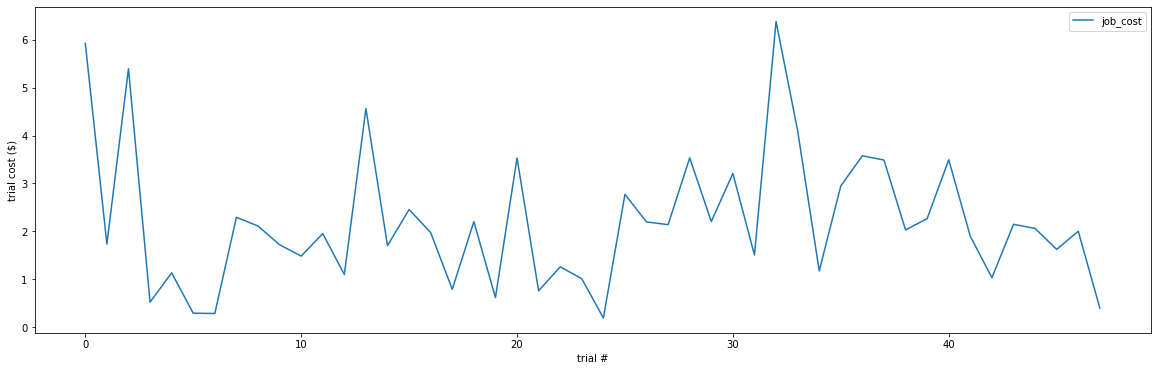

In [134]:
get_hpt_job_details(PROJECT_ID,'5067021821035937792')

In [358]:
#Create and upload the python package
# Location of python package:
PYTHON_PACKAGE_URI='gs://gcp-machine-learning-sandbox-aip-20220516215311/aiplatform-2022-05-16-21:54:23.828-aiplatform_custom_trainer_script-0.1.tar.gz'

### Define the metric evaluation function

In [106]:
#TRAIN_GPU, TRAIN_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_V100, 2) 

#DEPLOY_GPU, DEPLOY_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)
from datetime import datetime, timedelta

from google.cloud import aiplatform_v1

from time import sleep


TRAIN_VERSION = "tf-gpu.2-6"
#TRAIN_IMAGE = "us-central1-docker.pkg.dev/gcp-machine-learning-sandbox/docker-repo/tab_net_v2:gpu_v1112"
TRAIN_IMAGE = "gcr.io/tabnet-309522/tab_net_v2@sha256:9a3547b99efce4a7c510f9eb9dd246524de1978a016e2c42534855a770adf4c1"
print("Training:", TRAIN_IMAGE)

def RunCustomJob(trial_id, machine_type, accelerator_type, accelerator_count):
    
    TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
    
    print(("=========== Start Trial: [{}] =============").format(trial_id))
        
    # # Setup python package
    # python_package_spec = aiplatform_v1.PythonPackageSpec()
    # python_package_spec.executor_image_uri=TRAIN_IMAGE
    # python_package_spec.package_uris=[PYTHON_PACKAGE_URI]
    # python_package_spec.python_module='aiplatform_custom_trainer_script.task'
    # python_package_spec.args=["--epochs=100","--batch_size=128","--distribute=mirror"]
    
    # Container spec for TabNet_v2
    container_spec = aiplatform_v1.ContainerSpec()
    container_spec.image_uri=TRAIN_IMAGE
    container_spec.args=[
          "--preprocess",
          "--prediction_raw_inputs",
          "--exclude_key",
          "--data_has_header",
          "--training_data_path=gs://gcp-machine-learning-sandbox-aip-20220518215815/data/petfinder/train.csv",
          "--job-dir=gs://gcp-machine-learning-sandbox-aip-20220518215815/petfinder_tabnet_classification_" + TIMESTAMP,
          "--model_type=classification",
          "--max_steps=2000",
          "--batch_size=4096",
          "--learning_rate=0.01"
        ]
    
    #Machine Spec
    machine_spec = aiplatform_v1.MachineSpec()
    machine_spec.machine_type=machine_type
    machine_spec.accelerator_type=accelerator_type
    machine_spec.accelerator_count=accelerator_count
    
    #WorkerPoolSpec
    worker_pool_spec=aiplatform_v1.WorkerPoolSpec()
    worker_pool_spec.replica_count = 1
    worker_pool_spec.machine_spec = machine_spec
    #worker_pool_spec.python_package_spec = python_package_spec
    worker_pool_spec.container_spec = container_spec
    
    #Custom Job 
    
    custom_job = aiplatform_v1.CustomJob()
    custom_job.display_name=f'Cost_optimize_trial_{trial_id}_{machine_type}_{accelerator_type}_x_{accelerator_count}'
    custom_job.job_spec.base_output_directory.output_uri_prefix=f"gs://gcp-machine-learning-sandbox-aip-20220516215311/aiplatform-custom-training-rjv-{trial_id}"
    custom_job.job_spec.worker_pool_specs = [worker_pool_spec]

    client = aiplatform_v1.JobServiceClient(client_options=dict(api_endpoint=ENDPOINT))

    # Initialize request argument(s)
    request = aiplatform_v1.CreateCustomJobRequest(
        parent=f'projects/{PROJECT_ID}/locations/{LOCATION}',
        custom_job=custom_job,
    )

    # Make the request
    response = client.create_custom_job(request=request)
    
    # for use downstream
    job_details = client.parse_custom_job_path(response.name)
    
    
    #Vertex Job States
    # JOB_STATE_UNSPECIFIED	The job state is unspecified.
    # JOB_STATE_QUEUED	The job has been just created or resumed and processing has not yet begun.
    # JOB_STATE_PENDING	The service is preparing to run the job.
    # JOB_STATE_RUNNING	The job is in progress.
    # JOB_STATE_SUCCEEDED	The job completed successfully.
    # JOB_STATE_FAILED	The job failed.
    # JOB_STATE_CANCELLING	The job is being cancelled. From this state the job may only go to either JOB_STATE_SUCCEEDED, JOB_STATE_FAILED or JOB_STATE_CANCELLED.
    # JOB_STATE_CANCELLED	The job has been cancelled.
    # JOB_STATE_PAUSED	The job has been stopped, and can be resumed.
    # JOB_STATE_EXPIRED
    
    while response.state.name not in ('JOB_STATE_SUCCEEDED', 'JOB_STATE_FAILED','JOB_STATE_CANCELLED'):
        sleep(30)
        response = client.get_custom_job(name=response.name)
    
    #
    gpu_utilization = get_gpu_utilization(job_details['project'], job_details['custom_job'], response.start_time, response.end_time)
    job_duration = (response.end_time - response.start_time)/timedelta(hours=1)
    job_cost = get_hourly_price(machine_type, accelerator_type,accelerator_count) * job_duration
    
    return [{"metric_id": "training_time","value":job_duration},{"metric_id": "estimated_training_cost","value":job_cost},{"metric_id": "average_gpu_utilization","value":gpu_utilization}]
            


Training: gcr.io/tabnet-309522/tab_net_v2@sha256:9a3547b99efce4a7c510f9eb9dd246524de1978a016e2c42534855a770adf4c1


In [206]:
NOTES = "TEST_A100_HYPERPREDICT"
JOB_ID = !echo eats_home_feed_ranking_${NOTES}_$(date '+%Y%m%d_%H%M%S')
JOB_ID

['eats_home_feed_ranking_20220525_192935']

In [113]:
LOCATION='us-central1'

In [ ]:
#ATO RISK V1

In [114]:
LOCATION

'us-central1'

In [135]:
machine_name = 'n1-highmem-8'
vcpus = machine_name.split('-')[-1]
vcpus

'8'

In [320]:
DEFAULT_STUDY_SPEC= {
  "metrics": [
    {
      "metric_id": "auc",
      "goal": "MAXIMIZE"
    }
  ],
"parameters": [
   {
     "parameter_id": "max_steps",
     "integer_value_spec": {
       "min_value": "20000",
       "max_value": "50000"
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "feature_dim",
     "integer_value_spec": {
       "min_value": "30",
       "max_value": "160"
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "feature_dim_ratio",
     "double_value_spec": {
       "min_value": 0.5,
       "max_value": 0.7
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "num_decision_steps",
     "integer_value_spec": {
       "min_value": "4",
       "max_value": "8"
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "num_transformer_layers",
     "integer_value_spec": {
       "min_value": "4",
       "max_value": "8"
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "num_transformer_layers_ratio",
     "double_value_spec": {
       "min_value": 0.3,
       "max_value": 0.6
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "relaxation_factor",
     "double_value_spec": {
       "min_value": 2,
       "max_value": 4.5
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "decay_every",
     "double_value_spec": {
       "min_value": 20000,
       "max_value": 50000
     },
     "scale_type": "UNIT_LOG_SCALE"
   },
   {
     "parameter_id": "decay_rate",
     "double_value_spec": {
       "min_value": 0.7,
       "max_value": 0.95
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "batch_momentum",
     "double_value_spec": {
       "min_value": 0.6,
       "max_value": 0.95
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "learning_rate",
     "double_value_spec": {
       "min_value": 0.003,
       "max_value": 0.008
     },
     "scale_type": "UNIT_LOG_SCALE"
   },
   {
     "parameter_id": "batch_size_ratio",
     "double_value_spec": {
       "min_value": 0.3,
       "max_value": 0.5
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "sparsity_loss_weight",
     "double_value_spec": {
       "min_value": 1e-7,
       "max_value": 0.001
     },
     "scale_type": "UNIT_LOG_SCALE"
   },
   {
     "parameter_id": "batch_size",
     "integer_value_spec": {
       "min_value": "7084",
       "max_value": "37536"
     },
     "scale_type": "UNIT_LINEAR_SCALE"
   },
   {
     "parameter_id": "class_weight",
     "double_value_spec": {
       "min_value": 0.2,
       "max_value": 0.7
     },
     "scale_type": "UNIT_LOG_SCALE"
   }
 ]
}

In [579]:
#JSON FORMAT
long_trips_study_spec = {
    "metrics": [
      {
        "metricId": "mae",
        "goal": "MINIMIZE"
      }
    ],
    "parameters": [
      {
        "parameter_id": "max_steps",
        "integer_value_spec": {
          "min_value": "60500",
          "max_value": "80000"
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "feature_dim",
        "integerValueSpec": {
          "minValue": "128",
          "maxValue": "324"
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "feature_dim_ratio",
        "doubleValueSpec": {
          "minValue": 0.5,
          "maxValue": 0.7
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "num_decision_steps",
        "integerValueSpec": {
          "minValue": "4",
          "maxValue": "10"
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "num_transformer_layers",
        "integerValueSpec": {
          "minValue": "4",
          "maxValue": "10"
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "num_transformer_layers_ratio",
        "doubleValueSpec": {
          "minValue": 0.4,
          "maxValue": 0.6
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "relaxation_factor",
        "doubleValueSpec": {
          "minValue": 1.3,
          "maxValue": 3.5
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "decay_every",
        "doubleValueSpec": {
          "minValue": 10000,
          "maxValue": 50000
        },
        "scaleType": "UNIT_LOG_SCALE"
      },
      {
        "parameterId": "decay_rate",
        "doubleValueSpec": {
          "minValue": 0.7,
          "maxValue": 0.99
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "batch_momentum",
        "doubleValueSpec": {
          "minValue": 0.5,
          "maxValue": 0.95
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "learning_rate",
        "doubleValueSpec": {
          "minValue": 0.0002,
          "maxValue": 0.005
        },
        "scaleType": "UNIT_LOG_SCALE"
      },
      {
        "parameterId": "batch_size_ratio",
        "doubleValueSpec": {
          "minValue": 0.1,
          "maxValue": 0.4
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      },
      {
        "parameterId": "sparsity_loss_weight",
        "doubleValueSpec": {
          "minValue": 0.000001,
          "maxValue": 0.1
        },
        "scaleType": "UNIT_LOG_SCALE"
      },
      {
        "parameterId": "batch_size",
        "integerValueSpec": {
          "minValue": "2048",
          "maxValue": "16384"
        },
        "scaleType": "UNIT_LINEAR_SCALE"
      }
    ]
  }

ltss = json_format.MessageToDict(json_format.ParseDict(long_trips_study_spec,aiplatform_v1.StudySpec()._pb),preserving_proto_field_name=True)

In [399]:
# Parse output of hyperpredict files and generate study specs
import re

def parse_hyperpredict_params(dataset,study_spec=DEFAULT_STUDY_SPEC):
    hparams = {}
    revised_spec = study_spec.copy()
    with open(f"hyperpredict_study_specs/{dataset}.txt") as file:
        for line in file:
            m = re.match("\('(\w+)'.+\[(.+)\]\)",line.rstrip())
            if m:
                hparams[m.group(1)]= m.group(2).split(',')
                
    for i,param in enumerate(study_spec['parameters']):
        
        if param['parameter_id'] in hparams:
            min = hparams[param['parameter_id']][0]
            max = hparams[param['parameter_id']][1]
            if 'integer_value_spec' in param:
                revised_spec['parameters'][i]['integer_value_spec'] = {"min_value":int(min),"max_value":int(max) }
            else:
                revised_spec['parameters'][i]['double_value_spec'] = {"min_value":float(min),"max_value":float(max) }
    return revised_spec
                
#parse_hyperpredict_params("login_2fa")

In [411]:
# Read in Job Trial Specs for each dataset
def get_job_trial_specs(dataset):    
    datasets = {
        "ato_risk_v1":[],
        "login_2fa":[],
        "long_trips":[],
        "prep_time":[],
        "home_eats":[]
    }
    
    if dataset not in datasets:
        raise Exception("Unknown dataset")
    
    filename = f"trial_job_specs/{dataset}.txt"
    with open(filename) as file:
            data = file.read().replace('\n', '').replace('"', '')
            trial_specs = data.split(',')
    return trial_specs

get_job_trial_specs('login_2fa')
    

['--training_data_path=sungyong-internship.uber_dataset.login_2fa_split_train_uuid',
 '--test_data_path=sungyong-internship.uber_dataset.login_2fa_test',
 '--validation_data_path=sungyong-internship.uber_dataset.login_2fa_split_valid_uuid',
 '--model_type=classification',
 '--input_metadata_path=gs://uber-tabnet-poc/metadata/login_2fa_split_train_metadata_quantiles.json',
 '--input_type=bigquery',
 '--deterministic_data=False',
 '--target_column=\\label\\']

### James - start here for looking at how to run a TabNet H-tune job

In [626]:
from datetime import datetime, timedelta

from google.cloud import aiplatform_v1

from time import sleep

from google.cloud import aiplatform_v1

def create_hyperparameter_tuning_job(job_prefix,replica_count=1,max_trial_count=100,parallel_trial_count=10, max_failed_trial_count=10, machine_spec={
        "machine_type": "n1-highmem-8",
        "accelerator_type": "NVIDIA_TESLA_T4",
        "accelerator_count": 2
      },study_spec=DEFAULT_STUDY_SPEC,use_legacy_aip=False):
    
    machine_config = machine_spec['machine_type']
    vcpus = machine_config.split('-')[-1]

    if 'accelerator_type' in machine_spec:
        machine_config += f"_{machine_spec['accelerator_type']}_x{machine_spec['accelerator_count']}"
    else:
        machine_config += "_CPU_ONLY"
    
    display_name = f"{job_prefix}_{machine_config}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    # Create a client
    client = aiplatform_v1.JobServiceClient(client_options=dict(api_endpoint=ENDPOINT))
    
    # Get job specific study_spec and trial_spec
    study_spec = aiplatform_v1.StudySpec(parse_hyperpredict_params(job_prefix,study_spec=study_spec))
    job_trial_spec = get_job_trial_specs(job_prefix)

    # Initialize request argument(s)
    hyperparameter_tuning_job = aiplatform_v1.HyperparameterTuningJob()
    hyperparameter_tuning_job.display_name = display_name
    hyperparameter_tuning_job.study_spec = study_spec
    hyperparameter_tuning_job.max_trial_count = max_trial_count
    hyperparameter_tuning_job.parallel_trial_count = parallel_trial_count
    #hyperparameter_tuning_job.enable_trial_early_stopping = True
    hyperparameter_tuning_job.max_failed_trial_count = max_failed_trial_count 


    hyperparameter_tuning_job.trial_job_spec.worker_pool_specs =   [
    {
      "machine_spec": machine_spec,
      "replica_count": replica_count,
      "disk_spec": {
          "boot_disk_type": "pd-ssd",
          "boot_disk_size_gb": 100
      },
      "container_spec": {
        "image_uri": TRAIN_IMAGE,
        "args": [
           "--eval_frequency_secs=3600000",
            f"--num_parallel_reads=4",
            #f"--num_parallel_reads={vcpus}",
            "--optimizer_type=adam",
            "--data_cache=disk",
            "--stream_inputs",
            # "--training_data_path=sungyong-internship.uber_dataset.ato_risk_v1_split_train",
            # "--validation_data_path=sungyong-internship.uber_dataset.ato_risk_v1_split_valid",
            # "--test_data_path=sungyong-internship.uber_dataset.ato_risk_v1_test",
            # "--input_metadata_path=gs://tabnet-poc-cost-optimization/metadata/ato_risk_v1_train_metadata.json",
            # "--input_type=bigquery",
            # "--model_type=classification",
            # "--target_column=did_order"
          # RJV - Added
          f"--job-dir=gs://tabnet-poc-cost-optimization/{display_name}/",
        ] + job_trial_spec
      }
    }
  ]

    request = aiplatform_v1.CreateHyperparameterTuningJobRequest(
        parent=f'projects/{PROJECT_ID}/locations/{LOCATION}',
        hyperparameter_tuning_job=hyperparameter_tuning_job,
    )

    #run on legacy AIP
    if use_legacy_aip:
        from googleapiclient import discovery

        job_spec = convert_vertex_hpt_to_aip_hpt(hyperparameter_tuning_job)
        project_path = f'projects/{PROJECT_ID}'
        
        cloudml = discovery.build('ml', 'v1')
        request = cloudml.projects().jobs().create(body=job_spec,
              parent=project_path)
        response = request.execute()

        
    else:
        # Make the request
        response = client.create_hyperparameter_tuning_job(request=request)

        # Handle the response
        print(response)
    

In [628]:
from google.protobuf import json_format

def convert_study_spec_to_list(study_spec):
    params = []
    for parameter in study_spec.parameters:
        if 'integer_value_spec' in parameter:
            paramType = 'INTEGER'
            min_value = parameter.integer_value_spec.min_value
            max_value = parameter.integer_value_spec.max_value
        elif 'double_value_spec' in parameter:
            paramType = 'DOUBLE'
            min_value = parameter.double_value_spec.min_value
            max_value = parameter.double_value_spec.max_value
            
        params.append({
            'parameterName':parameter.parameter_id,
            'type':paramType,
            'minValue':min_value,
            'maxValue':max_value,
            'scaleType':parameter.scale_type.name
        })
    return params
        
def convert_vertex_hpt_to_aip_hpt(vertex_hpt_job):
        
    machine_type = vertex_hpt_job.trial_job_spec.worker_pool_specs[0].machine_spec.machine_type
    accelerator_type = vertex_hpt_job.trial_job_spec.worker_pool_specs[0].machine_spec.accelerator_type
    accelerator_count = vertex_hpt_job.trial_job_spec.worker_pool_specs[0].machine_spec.accelerator_count
    
    replica_count = vertex_hpt_job.trial_job_spec.worker_pool_specs[0].replica_count
    args = vertex_hpt_job.trial_job_spec.worker_pool_specs[0].container_spec.args[:]
    image_uri = vertex_hpt_job.trial_job_spec.worker_pool_specs[0].container_spec.image_uri
    
    boot_disk_type = vertex_hpt_job.trial_job_spec.worker_pool_specs[0].disk_spec.boot_disk_type
    boot_disk_size = vertex_hpt_job.trial_job_spec.worker_pool_specs[0].disk_spec.boot_disk_size_gb

    replica_config = {
          "acceleratorConfig": {
            "type": accelerator_type.name,
            "count": accelerator_count
          },
          "imageUri": image_uri,
           "diskConfig": {
              "bootDiskType": boot_disk_type,
              "bootDiskSizeGb": boot_disk_size
           },
          "containerArgs": args
        }
    

    training_inputs = {
        'scaleTier': 'CUSTOM',
        'masterType': machine_type,
        'masterConfig': replica_config,
        # 'workerType': machine_type,
        # 'workerConfig':replica_config,
        #'workerCount': replica_count,
        'region': 'us-central1',
    }
    
    
    
    hyperparams = {
        'goal':vertex_hpt_job.study_spec.metrics[0].goal.name,
        'hyperparameterMetricTag':vertex_hpt_job.study_spec.metrics[0].metric_id,
        'maxTrials':vertex_hpt_job.max_trial_count,
        'maxParallelTrials': vertex_hpt_job.parallel_trial_count,
        'maxFailedTrials':vertex_hpt_job.max_failed_trial_count,
        'params':convert_study_spec_to_list(vertex_hpt_job.study_spec)
    }
        
    
    training_inputs["hyperparameters"]= hyperparams

    job_spec = {
        'jobId':vertex_hpt_job.display_name.replace('-','_'),
        'trainingInput':training_inputs
    }
    #print(json.dumps(job_spec,indent=4))
    return job_spec
    

In [586]:
create_hyperparameter_tuning_job("ato_risk_v1",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "n1-highmem-16","accelerator_type": "NVIDIA_TESLA_T4","accelerator_count": 1},use_legacy_aip=True)


{
  "jobId": "ato_risk_v1_n1_highmem_16_NVIDIA_TESLA_T4_x1_20220801_185327",
  "trainingInput": {
    "hyperparameters": {
      "goal": "MAXIMIZE",
      "hyperparameterMetricTag": "auc",
      "maxTrials": 400,
      "maxParallelTrials": 20,
      "maxFailedTrials": 10,
      "params": [
        {
          "parameterName": "max_steps",
          "type": "INTEGER",
          "minValue": 2000,
          "maxValue": 58786,
          "scaleType": "UNIT_LINEAR_SCALE"
        },
        {
          "parameterName": "feature_dim",
          "type": "INTEGER",
          "minValue": 64,
          "maxValue": 360,
          "scaleType": "UNIT_LINEAR_SCALE"
        },
        {
          "parameterName": "feature_dim_ratio",
          "type": "DOUBLE",
          "minValue": 0.3,
          "maxValue": 0.6000000000000001,
          "scaleType": "UNIT_LINEAR_SCALE"
        },
        {
          "parameterName": "num_decision_steps",
          "type": "INTEGER",
          "minValue": 2,
         

HttpError: <HttpError 500 when requesting https://ml.googleapis.com/v1/projects/sungyong-internship/jobs?alt=json returned "Internal error encountered.". Details: "Internal error encountered.">

### login_2fa

In [ ]:

#login_2fa cost optimized
#create_hyperparameter_tuning_job("login_2fa",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "e2-standard-16"})

#login_2fa balanced
#create_hyperparameter_tuning_job("login_2fa",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "c2-standard-16"})

#login_2fa performance
#create_hyperparameter_tuning_job("login_2fa",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "n1-highmem-16","accelerator_type": "NVIDIA_TESLA_V100","accelerator_count": 2})

#login_2fa balanced - GPU
#create_hyperparameter_tuning_job("login_2fa",replica_count=1,max_trial_count=420,parallel_trial_count=30,max_failed_trial_count=10,machine_spec={"machine_type": "n1-highmem-16","accelerator_type": "NVIDIA_TESLA_T4","accelerator_count": 1})

#login_2fa performance - GPU
#create_hyperparameter_tuning_job("login_2fa",replica_count=1,max_trial_count=420,parallel_trial_count=5,max_failed_trial_count=10,machine_spec={"machine_type": "a2-highgpu-1g","accelerator_type": "NVIDIA_TESLA_A100","accelerator_count": 1})


#create_hyperparameter_tuning_job("login_2fa",replica_count=1,max_trial_count=400,parallel_trial_count=8,max_failed_trial_count=10,machine_spec={"machine_type": "n1-highmem-16","accelerator_type": "NVIDIA_TESLA_T4","accelerator_count": 1},study_spec)


### ato_risk_v1

In [562]:
#ato_risk cost optimized - CPU
#create_hyperparameter_tuning_job("ato_risk_v1",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "e2-highmem-16"})

#ato_risk balanced - CPU
#create_hyperparameter_tuning_job("ato_risk_v1",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "c2-standard-16"})

#ato_risk performance
#create_hyperparameter_tuning_job("ato_risk_v1",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "n1-highmem-16","accelerator_type": "NVIDIA_TESLA_V100","accelerator_count": 2})

#ato risk cost optimized - GPU
#create_hyperparameter_tuning_job("ato_risk_v1",replica_count=1,max_trial_count=420,parallel_trial_count=30,max_failed_trial_count=10,machine_spec={"machine_type": "n1-highmem-16","accelerator_type": "NVIDIA_TESLA_T4","accelerator_count": 1})




name: "projects/712758616004/locations/us-central1/hyperparameterTuningJobs/5745746775449272320"
display_name: "ato_risk_v1_n1-highmem-16_NVIDIA_TESLA_T4_x1_20220801_182857"
study_spec {
  metrics {
    metric_id: "auc"
    goal: MAXIMIZE
  }
  parameters {
    parameter_id: "max_steps"
    integer_value_spec {
      min_value: 2000
      max_value: 58786
    }
    scale_type: UNIT_LINEAR_SCALE
  }
  parameters {
    parameter_id: "feature_dim"
    integer_value_spec {
      min_value: 64
      max_value: 360
    }
    scale_type: UNIT_LINEAR_SCALE
  }
  parameters {
    parameter_id: "feature_dim_ratio"
    double_value_spec {
      min_value: 0.3
      max_value: 0.6000000000000001
    }
    scale_type: UNIT_LINEAR_SCALE
  }
  parameters {
    parameter_id: "num_decision_steps"
    integer_value_spec {
      min_value: 2
      max_value: 7
    }
    scale_type: UNIT_LINEAR_SCALE
  }
  parameters {
    parameter_id: "num_transformer_layers"
    integer_value_spec {
      min_value: 2


### long_trips

In [635]:
#long_trips cost optimized - CPU
#create_hyperparameter_tuning_job("long_trips",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "e2-highmem-16"},study_spec=ltss,use_legacy_aip=True)

#long_trips balanced - CPU - NOT SUPPORTED in Legacy AIP
#create_hyperparameter_tuning_job("long_trips",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "c2-highmem-16"},study_spec=ltss,use_legacy_aip=True)

#long_trips cost_optimized - GPU - 1 x T4 - Only 12 T4s in AIP
#create_hyperparameter_tuning_job("long_trips",replica_count=1,max_trial_count=396,parallel_trial_count=12,max_failed_trial_count=10,machine_spec={"machine_type": "n1-highmem-16","accelerator_type": "NVIDIA_TESLA_T4","accelerator_count": 1},study_spec=ltss,use_legacy_aip=True)

#long_trips performance - GPU - 2 x v100
#create_hyperparameter_tuning_job("long_trips",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "n1-highmem-16","accelerator_type": "NVIDIA_TESLA_V100","accelerator_count": 2},study_spec=ltss,use_legacy_aip=True)

#long_trips performance - A100
create_hyperparameter_tuning_job("long_trips",replica_count=1,max_trial_count=400,parallel_trial_count=20,max_failed_trial_count=10,machine_spec={"machine_type": "a2-highgpu-1g","accelerator_type": "NVIDIA_TESLA_A100","accelerator_count": 1},study_spec=ltss,use_legacy_aip=True)



In [232]:
!gsutil mb 'gs:/tabnet-poc-cost-optimization/eats_home_feed_ranking_n1-highmem-8_NVIDIA_TESLA_V100_x2'

CommandException: "mb" command does not support "file://" URLs. Did you mean to use a gs:// URL?


In [ ]:
metrics = RunCustomJob('100-T4','n1-standard-8','NVIDIA_TESLA_T4',2)


### Set configuration parameters for running trials

__`client_id`__: The identifier of the client that is requesting the suggestion. If multiple SuggestTrialsRequests have the same `client_id`, the service will return the identical suggested trial if the trial is `PENDING`, and provide a new trial if the last suggested trial was completed.

__`suggestion_count_per_request`__: The number of suggestions (trials) requested in a single request.

__`max_trial_id_to_stop`__: The number of trials to explore before stopping. It is set to 4 to shorten the time to run the code, so don't expect convergence. For convergence, it would likely need to be about 20 (a good rule of thumb is to multiply the total dimensionality by 10).


In [461]:
client_id = "Vertex Workbench Client"  # @param {type: 'string'}
suggestion_count_per_request = 1  # @param {type: 'integer'}
max_trial_id_to_stop = 10  # @param {type: 'integer'}

print("client_id: {}".format(client_id))
print("suggestion_count_per_request: {}".format(suggestion_count_per_request))
print("max_trial_id_to_stop: {}".format(max_trial_id_to_stop))

client_id: Vertex Workbench Client
suggestion_count_per_request: 1
max_trial_id_to_stop: 10


### Run Vertex Vizier trials

Run the trials.

In [464]:
trial_id = 0
while int(trial_id) < max_trial_id_to_stop:
    suggest_response = vizier_client.suggest_trials(
        {
            "parent": STUDY_ID,
            "suggestion_count": suggestion_count_per_request,
            "client_id": client_id,
        }
    )

    for suggested_trial in suggest_response.result().trials:
        trial_id = suggested_trial.name.split("/")[-1]
        trial = vizier_client.get_trial({"name": suggested_trial.name})

        if trial.state in ["COMPLETED", "INFEASIBLE"]:
            continue

        for param in trial.parameters:
            if param.parameter_id == "machine_type":
                machine_type = param.value
            elif param.parameter_id == "gpu_type":
                gpu_type = param.value
            elif param.parameter_id == "gpu_count":
                gpu_count = param.value
        print(f"Trial : machine_type is {machine_type}, gpu_type is {gpu_type}, gpu_count is {gpu_count}.")
        
        metrics = RunCustomJob(trial_id, machine_type, gpu_type, int(gpu_count))

        vizier_client.add_trial_measurement(
            {
                "trial_name": suggested_trial.name,
                "measurement": {
                    "metrics": metrics
                },
            }
        )
        response = vizier_client.complete_trial(
            {"name": suggested_trial.name, "trial_infeasible": False}
        )

Trial : machine_type is n1-standard-4, gpu_type is NVIDIA_TESLA_T4, gpu_count is 2.0.
=========== Start Trial: [1] =============


E0519 15:43:09.160064325   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 15:51:41.911130468   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 15:51:43.381916601   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Trial : machine_type is n1-standard-4, gpu_type is NVIDIA_TESLA_K80, gpu_count is 2.0.
=========== Start Trial: [2] =============


E0519 15:51:46.194349494   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:01:49.073136445   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:01:50.544098369   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Trial : machine_type is n1-standard-4, gpu_type is NVIDIA_TESLA_T4, gpu_count is 4.0.
=========== Start Trial: [3] =============


E0519 16:01:59.082182048   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:15:33.580464486   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:15:34.691489531   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Trial : machine_type is n1-standard-8, gpu_type is NVIDIA_TESLA_P4, gpu_count is 2.0.
=========== Start Trial: [4] =============


E0519 16:15:45.085159833   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:24:47.975833812   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:24:49.549004013   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Trial : machine_type is n1-standard-8, gpu_type is NVIDIA_TESLA_T4, gpu_count is 2.0.
=========== Start Trial: [5] =============


E0519 16:24:55.473171404   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:32:58.002507311   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:32:59.125995444   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Trial : machine_type is n1-standard-8, gpu_type is NVIDIA_TESLA_P100, gpu_count is 2.0.
=========== Start Trial: [6] =============


E0519 16:33:04.594049939   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:41:07.024582640   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies
E0519 16:41:08.131228042   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Trial : machine_type is n1-standard-8, gpu_type is NVIDIA_TESLA_T4, gpu_count is 4.0.
=========== Start Trial: [7] =============


E0519 16:41:16.639021317   21151 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


KeyboardInterrupt: 

### List the optimal solutions

list_optimal_trials returns the pareto-optimal Trials for multi-objective Study or the optimal Trials for single-objective Study. In the case, we define mutliple-objective in previeous steps, pareto-optimal trials will be returned.

In [440]:
optimal_trials = vizier_client.list_optimal_trials({"parent": STUDY_ID})

print("optimal_trials: {}".format(optimal_trials))

optimal_trials: optimal_trials {
  name: "projects/497728924767/locations/us-central1/studies/2246293698204/trials/2"
  state: SUCCEEDED
  parameters {
    parameter_id: "gpu_count"
    value {
      number_value: 1.0
    }
  }
  parameters {
    parameter_id: "gpu_type"
    value {
      string_value: "NVIDIA_TESLA_P4"
    }
  }
  parameters {
    parameter_id: "machine_type"
    value {
      string_value: "n1-standard-4"
    }
  }
  final_measurement {
    metrics {
      metric_id: "training_time"
      value: 0.016666666666666666
    }
    metrics {
      metric_id: "estimated_training_cost"
      value: 0.0151416475
    }
    metrics {
      metric_id: "average_gpu_utilization"
      value: -1.0
    }
  }
  measurements {
    metrics {
      metric_id: "training_time"
      value: 0.016666666666666666
    }
    metrics {
      metric_id: "estimated_training_cost"
      value: 0.0151416475
    }
    metrics {
      metric_id: "average_gpu_utilization"
      value: -1.0
    }
  }
 

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial. You can also manually delete resources that you created by running the following code.

In [ ]:
vizier_client.delete_study({"name": STUDY_ID})